In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Quantum GANs {#quantum_gans}
============

::: {.meta}
:property=\"og:description\": Explore quantum GANs to generate
hand-written digits of zero :property=\"og:image\":
<https://pennylane.ai/qml/_images/patch.jpeg>
:::

::: {.related}
tutorial\_QGAN Quantum generative adversarial networks with Cirq +
TensorFlow
:::


*Author: James Ellis --- Posted: 01 February 2022. Last updated: 27
January 2022.*

In this tutorial, we will explore quantum GANs to generate hand-written
digits of zero. We will first cover the theory of the classical case,
then extend to a quantum method recently proposed in the literature. If
you have no experience with GANs, particularly in PyTorch, you might
find [PyTorch\'s
tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
useful since it serves as the foundation for what is to follow.


Generative Adversarial Networks (GANs)
======================================


The goal of generative adversarial networks (GANs) is to generate data
that resembles the original data used in training. To achieve this, we
train two neural networks simulatenously: a generator and a
discriminator. The job of the generator is to create fake data which
imitates the real training dataset. On the otherhand, the discriminator
acts like a detective trying to discern real from fake data. During the
training process, both players iteratively improve with one another. By
the end, the generator should hopefully generate new data very similar
to the training dataset.

Specifically, the training dataset represents samples drawn from some
unknown data distribution $P_{data}$, and the generator has the job of
trying to capture this distribution. The generator, $G$, starts from
some initial latent distribution, $P_z$, and maps it to $P_g = G(P_z)$.
The best solution would be for $P_g = P_{data}$. However, this point is
rarely achieved in practice apart from in the most simple tasks.

Both the discriminator, $D$, and generator, $G$, play in a 2-player
minimax game. The discriminator tries to maximise the probability of
discerning real from fake data, while the generator tries to minimise
the same probability. The value function for the game is summarised by,

$$\begin{aligned}
\begin{align}
\min_G \max_D V(D,G) &= \mathbb{E}_{\boldsymbol{x}\sim p_{data}}[\log D(\boldsymbol{x})] \\
    & ~~ + \mathbb{E}_{\boldsymbol{z}\sim p_{\boldsymbol{z}}}[\log(1 - D(G(\boldsymbol{z}))]
\end{align}
\end{aligned}$$

-   $\boldsymbol{x}$: real data sample
-   $\boldsymbol{z}$: latent vector
-   $D(\boldsymbol{x})$: probability of the discriminator classifying
    real data as real
-   $G(\boldsymbol{z})$: fake data
-   $D(G(\boldsymbol{z}))$: probability of discriminator classifying
    fake data as real

In practice, the two networks are trained iteratively, each with a
separate loss function to be minimised,

$$L_D = -[y \cdot \log(D(x)) + (1-y)\cdot \log(1-D(G(z)))]$$

$$L_G = [(1-y) \cdot \log(1-D(G(z)))]$$

where $y$ is a binary label for real ($y=1$) or fake ($y=0$) data. In
practice, generator training is shown to be more stable when made to
maximise $\log(D(G(z)))$ instead of minimising $\log(1-D(G(z)))$. Hence,
the generator loss function to be minimised becomes,

$$L_G = -[(1-y) \cdot \log(D(G(z)))]$$


Quantum GANs: The Patch Method
==============================


In this tutorial, we re-create one of the quantum GAN methods presented
by Huang et al.: the patch method. This method uses several quantum
generators, with each sub-generator, $G^{(i)}$, responsible for
constructing a small patch of the final image. The final image is
contructed by concatenting all of the patches together as shown below.

![](../demonstrations/quantum_gans/patch.jpeg){.align-center
width="90.0%"}

The main advantage of this method is that it is particulary suited to
situations where the number of available qubits are limited. The same
quantum device can be used for each sub-generator in an iterative
fashion, or execution of the generators can be parallelised across
multiple devices.

::: {.note}
::: {.title}
Note
:::

In this tutorial, parenthesised superscripts are used to denote
individual objects as part of a collection.
:::


Module Imports
==============


In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Data
====


As mentioned in the introduction, we will use a [small
dataset](https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits)
of handwritten zeros. First, we need to create a custom dataloader for
this dataset.


In [3]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

Next we define some variables and create the dataloader instance.


In [4]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

Let\'s visualize some of the data.


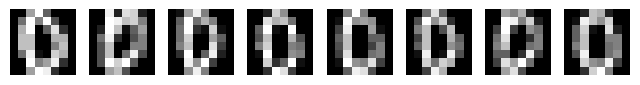

In [5]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show()

Implementing the Discriminator
==============================


For the discriminator, we use a fully connected neural network with two
hidden layers. A single output is sufficient to represent the
probability of an input being classified as real.


In [6]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

Implementing the Generator
==========================


Each sub-generator, $G^{(i)}$, shares the same circuit architecture as
shown below. The overall quantum generator consists of $N_G$
sub-generators, each consisting of $N$ qubits. The process from latent
vector input to image output can be split into four distinct sections:
state embedding, parameterisation, non-linear transformation, and
post-processing. Each of the following sections below refer to a single
iteration of the training process to simplify the discussion.

![](../demonstrations/quantum_gans/qcircuit.jpeg){.align-center
width="90.0%"}

**1) State Embedding**

A latent vector, $\boldsymbol{z}\in\mathbb{R}^N$, is sampled from a
uniform distribution in the interval $[0,\pi/2)$. All sub-generators
receive the same latent vector which is then embedded using RY gates.

**2) Parameterised Layers**

The parameterised layer consists of parameterised RY gates followed by
control Z gates. This layer is repeated $D$ times in total.

**3) Non-Linear Transform**

Quantum gates in the circuit model are unitary which, by definition,
linearly transform the quantum state. A linear mapping between the
latent and generator distribution would be suffice for only the most
simple generative tasks, hence we need non-linear transformations. We
will use ancillary qubits to help.

For a given sub-generator, the pre-measurement quantum state is given
by,

$$|\Psi(z)\rangle = U_{G}(\theta)|\boldsymbol{z}\rangle$$

where $U_{G}(\theta)$ represents the overall unitary of the
parameterised layers. Let us inspect the state when we take a partial
measurment, $\Pi$, and trace out the ancillary subsystem, $\mathcal{A}$,

$$\rho(\boldsymbol{z}) = \frac{\text{Tr}_{\mathcal{A}}(\Pi \otimes \mathbb{I} |\Psi(z)\rangle \langle \Psi(\boldsymbol{z})|) }{\text{Tr}(\Pi \otimes \mathbb{I} |\Psi(\boldsymbol{z})\rangle \langle \Psi(\boldsymbol{z})|))} = \frac{\text{Tr}_{\mathcal{A}}(\Pi \otimes \mathbb{I} |\Psi(\boldsymbol{z})\rangle \langle \Psi(\boldsymbol{z})|) }{\langle \Psi(\boldsymbol{z})| \Pi \otimes \mathbb{I} |\Psi(\boldsymbol{z})\rangle}$$

The post-measurement state, $\rho(\boldsymbol{z})$, is dependent on
$\boldsymbol{z}$ in both the numerator and denominator. This means the
state has been non-linearly transformed! For this tutorial,
$\Pi = (|0\rangle \langle0|)^{\otimes N_A}$, where $N_A$ is the number
of ancillary qubits in the system.

With the remaining data qubits, we measure the probability of
$\rho(\boldsymbol{z})$ in each computational basis state, $P(j)$, to
obtain the sub-generator output, $\boldsymbol{g}^{(i)}$,

$$\boldsymbol{g}^{(i)} = [P(0), P(1), ... ,P(2^{N-N_A} - 1)]$$

**4) Post Processing**

Due to the normalisation constraint of the measurment, all elements in
$\boldsymbol{g}^{(i)}$ must sum to one. This is a problem if we are to
use $\boldsymbol{g}^{(i)}$ as the pixel intensity values for our patch.
For example, imagine a hypothetical situation where a patch of full
intensity pixels was the target. The best patch a sub-generator could
produce would be a patch of pixels all at a magnitude of
$\frac{1}{2^{N-N_A}}$. To alleviate this constraint, we apply a
post-processing technique to each patch,

$$\boldsymbol{\tilde{x}^{(i)}} = \frac{\boldsymbol{g}^{(i)}}{\max_{k}\boldsymbol{g}_k^{(i)}}$$

Therefore, the final image, $\boldsymbol{\tilde{x}}$, is given by

$$\boldsymbol{\tilde{x}} = [\boldsymbol{\tilde{x}^{(1)}}, ... ,\boldsymbol{\tilde{x}^{(N_G)}}]$$


In [7]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

Now we define the quantum device we want to use, along with any
available CUDA GPUs (if available).


In [8]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

/Users/nicolas/opt/anaconda3/envs/PennyLane/lib/python3.9/site-packages/pennylane_lightning/lightning_qubit.py:893: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


device(type='cpu')

Next, we define the quantum circuit and measurement process described
above.


In [9]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

Now we create a quantum generator class to use during training.


In [10]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

Training
========


Let\'s define learning rates and number of iterations for the training
process.


In [11]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

Now putting everything together and executing the training process.


In [12]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values         
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()
            
            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.356, Generator Loss: 0.597
Iteration: 20, Discriminator Loss: 1.325, Generator Loss: 0.621
Iteration: 30, Discriminator Loss: 1.333, Generator Loss: 0.615
Iteration: 40, Discriminator Loss: 1.304, Generator Loss: 0.633
Iteration: 50, Discriminator Loss: 1.275, Generator Loss: 0.648
Iteration: 60, Discriminator Loss: 1.222, Generator Loss: 0.670
Iteration: 70, Discriminator Loss: 1.267, Generator Loss: 0.627
Iteration: 80, Discriminator Loss: 1.253, Generator Loss: 0.647
Iteration: 90, Discriminator Loss: 1.256, Generator Loss: 0.624
Iteration: 100, Discriminator Loss: 1.249, Generator Loss: 0.627
Iteration: 110, Discriminator Loss: 1.177, Generator Loss: 0.660
Iteration: 120, Discriminator Loss: 1.175, Generator Loss: 0.633
Iteration: 130, Discriminator Loss: 1.210, Generator Loss: 0.664
Iteration: 140, Discriminator Loss: 1.231, Generator Loss: 0.605
Iteration: 150, Discriminator Loss: 1.252, Generator Loss: 0.606
Iteration: 160, Discriminator Loss

::: {.note}
::: {.title}
Note
:::

You may have noticed `errG = criterion(outD_fake, real_labels)` and
wondered why we don't use `fake_labels` instead of `real_labels`.
However, this is simply a trick to be able to use the same `criterion`
function for both the generator and discriminator. Using `real_labels`
forces the generator loss function to use the $\log(D(G(z))$ term
instead of the $\log(1 - D(G(z))$ term of the binary cross entropy loss
function.
:::


Finally, we plot how the generated images evolved throughout training.


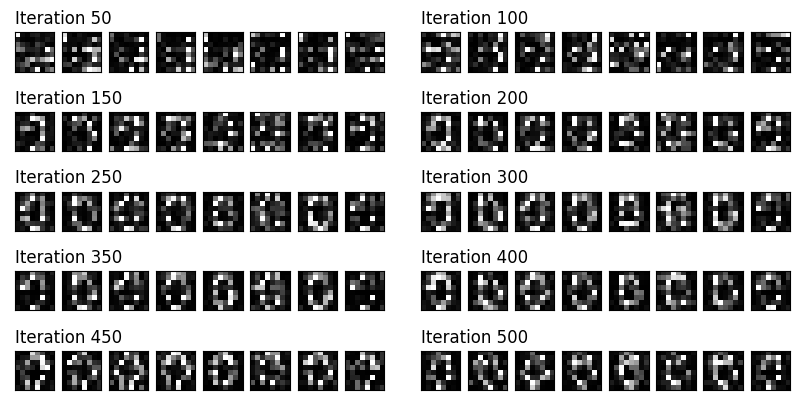

In [13]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])
    
    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

Acknowledgements
================

Many thanks to Karolis Špukas who I co-developed much of the code with.
I also extend my thanks to Dr. Yuxuan Du for answering my questions
regarding his paper. I am also indebited to the Pennylane community for
their help over the past few years.

References
==========

About the author
================
